In [1]:
# SPDX-FileCopyrightText: 2024-2025 Aleksander Grochowicz
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
# Initiation

import pypsa 

import matplotlib.pyplot as plt
import matplotlib as mpl


import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr

import geopandas as gpd
import cartopy.crs as ccrs

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator, FormatStrFormatter)
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from _notebook_utilities import *
from _generate_data_for_analysis import *
from _dashboard import *

import logging

# Suppress warnings and info messages from 'pypsa.io'
logging.getLogger("pypsa.io").setLevel(logging.ERROR)

mpl.rcParams["figure.dpi"] = 150

cm = 1 / 2.54  # centimeters in inches



In [3]:
# Inititate config file.
regenerate_data = False
config_name = "stressful-weather"

# In order to regenerate data, run `generate_data_for_analysis.py`.

# Load config, periods etc.
config, scenario_def, years, opt_networks = load_opt_networks(config_name, load_networks=regenerate_data)
periods = load_periods(config)

# Set colours for plots.
colours = {
    "DC":  "#8a1caf",
    "AC": "#70af1d",
    "biomass": "#baa741",
    "nuclear": "#ff8c00",
    "ror": "#3dbfb0",
    "fuel_cells": "#c251ae",
    "battery": "#ace37f",
    "phs": "#51dbcc",
    "hydro": "#298c81",
    }
colours["H2 fuel cell"] = colours["fuel_cells"]
colours["battery discharger"] = colours["battery"]
colours["PHS"] = colours["phs"]
# Create a colormap
cmap_midnights = mpl.colors.ListedColormap(["#2A1828", "#4F5D87", "#83A5BA", "#E8E7E3"])
# Alternative colormap going from white to #2F3C30
cmap_two = mpl.colors.ListedColormap(["#E8E7E3", "#2F3C30"])



In [4]:
# Load all data we might need that is pre-generated in `generate_data_for_analysis.py`.
folder = f"./processing_data/{config_name}"

# Load one network for reference and the layout.
n = pypsa.Network("../pypsa-eur/results/stressful-weather/weather_year_1941/networks/base_s_90_elec_lc1.25_Co2L.nc")

# Load: net load, total load, winter load
net_load = pd.read_csv(f"{folder}/net_load.csv", index_col=0, parse_dates=True)

nodal_load = pd.read_csv(f"{folder}/nodal_load.csv", index_col=0, parse_dates=True)

# Costs: nodal prices, total electricity/storage/fuel cell costs
all_prices = pd.read_csv(f"{folder}/all_prices.csv", index_col=0, parse_dates=True)
total_costs_df = pd.read_csv(f"{folder}/total_costs.csv", index_col=[0,1])
total_costs = {}
for year in years:
    df = total_costs_df.loc[year]
    df.index = pd.to_datetime(df.index)
    total_costs[year] = df["0"]

# Rewrite costs, storage costs and fuel cell costs in dictionaries for plotting alter.
total_system_costs = {}
for year in years:
    df = total_costs_df.loc[year]
    df.index = pd.to_datetime(df.index)
    total_system_costs[year] = df["0"]


# Objective values
opt_objs = pd.read_csv(f"{folder}/opt_objs.csv", index_col=0)
reindex_opt_objs = opt_objs.copy().sum(axis="columns") 
reindex_opt_objs.index=years
opt_objs["total"] = opt_objs.sum(axis="columns")
system_costs = opt_objs["total"]/1e9


## SDEs
# Stats for storage behaviour
stores_periods = pd.read_csv(f"{folder}/stores_periods.csv", index_col=0)

# Stats for clustering: net load peak hour, highest net load, avg net load, energy deficit, h2 discharge, max fc discharge, avg rel load, wind cf, wind anom, annual cost
stats_periods = pd.read_csv(f"{folder}/stats_periods.csv", index_col=0)

## FLEXIBILITY
# System: detailed
all_flex_detailed = pd.read_csv(f"{folder}/all_flex_detailed.csv", index_col=0, parse_dates=True)
all_system_anomaly = pd.read_csv(f"{folder}/all_system_anomaly.csv", index_col=0, parse_dates=True)
all_used_flexibility = pd.read_csv(f"{folder}/all_used_flexibility.csv", index_col=0, parse_dates=True)
all_flex_anomaly = pd.read_csv(f"{folder}/all_flex_anomaly.csv", index_col=0, parse_dates=True)


# Nodal
nodal_flex_p = pd.read_csv(f"{folder}/nodal_flex_p.csv", index_col=[0,1])
nodal_seasonality = pd.read_csv(f"{folder}/nodal_seasonality.csv", index_col=0, parse_dates=True)
nodal_flex_u = xr.open_dataset(f"{folder}/nodal_flex_u.nc")


## AVERAGES
# Load the means, anomalies.
load_means = pd.read_csv("../pypsa-eur/results/means/load_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)
solar_means = pd.read_csv("../pypsa-eur/results/means/solar_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)
wind_means = pd.read_csv("../pypsa-eur/results/means/wind_1941-2020_100bn_12-336h_90_elec_lc1.25_Co2L.csv", index_col=0, parse_dates=True)

# Capacity factors and capacities.
wind_cf = xr.open_dataset(f"{folder}/wind_cf.nc").to_dataframe()
solar_cf = xr.open_dataset(f"{folder}/solar_cf.nc").to_dataframe()
wind_caps = pd.read_csv(f"{folder}/wind_caps.csv", index_col=0)
solar_caps = pd.read_csv(f"{folder}/solar_caps.csv", index_col=0)
annual_cfs = pd.read_csv(f"{folder}/annual_cfs.csv", index_col=0)
winter_cfs = pd.read_csv(f"processing_data/{config_name}/winter_cfs.csv", index_col=0)

# Load load.
total_load = pd.read_csv(f"{folder}/total_load.csv", index_col=0, parse_dates=True)
nodal_load = pd.read_csv(f"{folder}/nodal_load.csv", index_col=0, parse_dates=True)
winter_load = pd.read_csv(f"{folder}/winter_load.csv", index_col=0)

# Load onshore and offshore regions for shapefile.
onshore_regions = gpd.read_file("../pypsa-eur/resources/stressful-weather/weather_year_1941/regions_onshore_base_s_90.geojson")
offshore_regions = gpd.read_file("../pypsa-eur/resources/stressful-weather/weather_year_1941/regions_offshore_base_s_90.geojson")

# Ranked years: NOTE that this refers to highest load shedding, not over the annual sum
# Need to run _unserved_energy.py to rerun this.
ranked_years = pd.read_csv(f"processing_data/stressful-weather-sensitivities/ranked_years.csv", index_col=0)

# Generate a dataframe with all necessary annual values: 
system_flex_p = (nodal_flex_p.unstack().sum(axis="rows") / 1e3).round(1)
flex_caps = system_flex_p[["battery discharger", "H2 fuel cell"]].unstack(level=0)
annual_values = collect_annual_values(ranked_years, annual_cfs, winter_load, total_system_costs, flex_caps, years)

# Load clusters
cluster_nr = 4
clusters = pd.read_csv(f"clustering/{config_name}/clustered_vals_{cluster_nr}.csv", index_col=0)["cluster"]
stats_periods["cluster"] = clusters

# Load one network for reference.
n = pypsa.Network(f"../pypsa-eur/results/{config_name}/weather_year_1941/networks/base_s_90_elec_lc1.25_Co2L.nc")




/tmp/ipykernel_82197/4293393919.py:54: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

# Table 1: Stats

# Figure 1: Capacities and generation profiles

In [5]:
df_system_flex = system_flex_p.unstack(level=0)
# Reorder df_system_flex to be of the form baseload, and then the order of how we dispatch during extreme events.
df_system_flex = df_system_flex[["nuclear", "biomass", "hydro", "PHS", "battery discharger", "H2 fuel cell"]]

cf_ranges = {}
for tech in ["nuclear", "biomass", "hydro", "phs", "battery", "fuel_cells", "AC", "DC"]:
    cf_ranges[tech] = ranges_across_years(all_flex_detailed[tech], years,resample="1D")

/tmp/ipykernel_82197/1653677488.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)
/tmp/ipykernel_82197/1653677488.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=90)
/tmp/ipykernel_82197/1653677488.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
/tmp/ipykernel_82197/1653677488.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=90)
/tmp/ipykernel_82197/1653677488.py:109: UserWarning: set_ticklabels() should only be

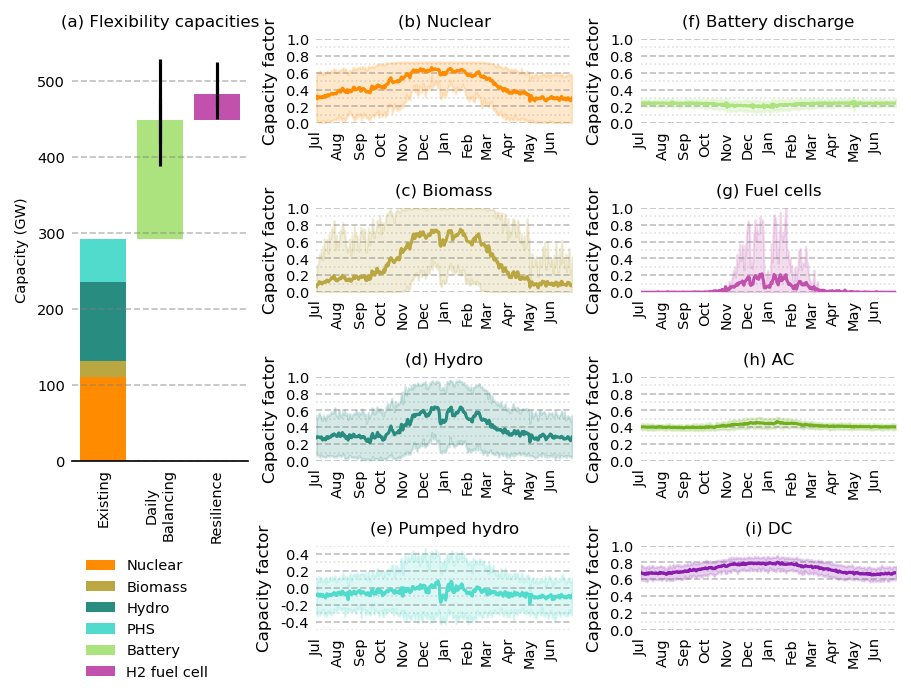

In [6]:
# Combine the above figures into one.

fig, axd = plt.subplot_mosaic(
    mosaic = [["caps", "nuclear", "battery"], 
             ["caps", "biomass", "fuel_cells"],
             ["caps", "hydro", "AC"],
             ["X", "phs", "DC"]],
    width_ratios = [4.6,6.7,6.7],
    height_ratios = [1,1,1,1],
    gridspec_kw={"hspace": 1, "wspace": 0.3},
    figsize = (18*cm, 13*cm),
    empty_sentinel="X",
)

## CAPACITY PLOT

ax = axd["caps"]
ax.set_title("(a) Flexibility capacities", fontsize=8)
rel_dispatch = df_system_flex[["nuclear", "biomass", "hydro", "PHS"]]

bottom_val = 0
for column, colour in zip(rel_dispatch.columns, [colours["nuclear"], colours["biomass"], colours["hydro"], colours["PHS"]]):
    ax.bar(
        0,
        rel_dispatch[column].mean(),
        bottom = bottom_val,
        yerr = rel_dispatch[column].std(),
        width = 0.8,
        color = colour,
    )
    bottom_val += rel_dispatch[column].mean()


for i, (column, colour) in enumerate(zip(["battery discharger", "H2 fuel cell"], [colours["battery"], colours["H2 fuel cell"]])):
    ax.bar(
        1 + i,
        df_system_flex[column].mean(),
        bottom = bottom_val,
        yerr = df_system_flex[column].std(),
        width = 0.8,
        color = colour,
    )
    error = np.array([[df_system_flex[column].mean() - df_system_flex[column].min()], [df_system_flex[column].max() - df_system_flex[column].mean()]])
    ax.errorbar(x=1 + i, y=bottom_val + df_system_flex[column].mean(), yerr=error, color='black')
    bottom_val += df_system_flex[column].mean()

## Aesthetics
# Add labels
ax.set_ylabel("Capacity (GW)", fontsize=7)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Existing", "Daily\nBalancing", "Resilience"], rotation=90, fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

# Remove spines
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=0)

# Add grid
ax.yaxis.grid(True, color="grey", linestyle="--", alpha=0.5)

ax.xaxis.grid(False)

# Add manual legend
legend_elements = [
    Patch(facecolor=colours["nuclear"], label="Nuclear"),
    Patch(facecolor=colours["biomass"], label="Biomass"),
    Patch(facecolor=colours["hydro"], label="Hydro"),
    Patch(facecolor=colours["PHS"], label="PHS"),
    Patch(facecolor=colours["battery"], label="Battery"),
    Patch(facecolor=colours["H2 fuel cell"], label="H2 fuel cell"),
]
ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(-0, -0.2), fontsize=7, frameon=False, ncol=1)

## SEASONALITY PLOTS

for ax, tech, colour, title in zip([axd["nuclear"], axd["biomass"], axd["hydro"], axd["phs"], axd["battery"], axd["fuel_cells"], axd["AC"], axd["DC"]], ["nuclear", "biomass", "hydro", "phs", "battery", "fuel_cells", "AC", "DC"], [colours["nuclear"], colours["biomass"], colours["hydro"], colours["PHS"], colours["battery"], colours["H2 fuel cell"], colours["AC"], colours["DC"]], ["(b) Nuclear", "(c) Biomass", "(d) Hydro", "(e) Pumped hydro", "(f) Battery discharge", "(g) Fuel cells", "(h) AC", "(i) DC"]):
    ax.plot(cf_ranges[tech].mean(axis=1), color=colour, label="Mean")
    ax.set_title(title, fontsize=8)
    ax.fill_between(
        cf_ranges[tech].index,
        cf_ranges[tech].quantile(0.1, axis=1),
        cf_ranges[tech].quantile(0.9, axis=1),
        color=colour,
        alpha=0.2,
    )
    # Add labels
    ax.set_ylabel("Capacity factor", fontsize=8)
    ax.tick_params(axis="both", which="both", length=0)
    # Remove spines
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)
    # Add grid
    ax.yaxis.grid(True, color="grey", linestyle="--", alpha=0.5)
    if tech == "phs":
        ax.set_ylim(-0.5, 0.5)
    else:
        ax.set_ylim(0, 1)

    # Add x-axis ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=90)
    ax.set_xlim(pd.Timestamp("1941-07-01"), pd.Timestamp("1942-06-30"))

     # y-axis.
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
    # Add grids
    ax.yaxis.grid(True, which="major", color="grey", linestyle="--", alpha=0.5)
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.grid(True, which="minor", color="grey", linestyle=":", alpha=0.25)

fig.savefig("paper_plots/capacities.pdf", bbox_inches="tight")



# Figure 2: Composite maps of system during SDEs

In [7]:
# Calculate nodal net load.
nodal_net_load = {}
for year in years:
    load = nodal_load.loc[f"{year}-07-01":f"{year+1}-06-30"].copy()
    solar_prod = solar_caps[str(year)] * solar_cf[f"{year}-07-01":f"{year+1}-06-30"]
    wind_prod = wind_caps[str(year)] * wind_cf[f"{year}-07-01":f"{year+1}-06-30"]
    solar_prod.columns = n.generators.loc[solar_prod.columns].bus.values
    solar_prod = solar_prod.groupby(solar_prod.columns, axis=1).sum().round(0)
    wind_prod.columns = n.generators.loc[wind_prod.columns].bus.values
    wind_prod = wind_prod.groupby(wind_prod.columns, axis=1).sum().round(0)
    nodal_net_load[year] = load - (solar_prod + wind_prod)
nodal_net_load = pd.concat(nodal_net_load.values(), axis=0)

net_load_means = average_across_years(nodal_net_load, years)

# Calculate all nodal costs.
nodal_costs = all_prices * nodal_load

fc_discharge = {}
for year in years:
    df_caps = nodal_flex_p["H2 fuel cell"].unstack()[year].T
    df_cf = nodal_flex_u["H2 fuel cell"].to_pandas().T.loc[f"{year}-07-01":f"{year+1}-06-30"]
    fc_discharge[year] = (df_cf * df_caps).round(1)

fc_discharge_df = pd.concat(fc_discharge.values(), axis=0)

dispatch_flex = {}
for year in years:
    dispatch_flex[year] = pd.DataFrame(0, columns = nodal_flex_p.index.levels[0], index = pd.date_range(f"{year}-07-01", f"{year+1}-06-30 23:00", freq="h")).fillna(0)
    for tech in ["nuclear", "biomass", "hydro", "PHS", "battery discharger", "H2 fuel cell"]:
        df_caps = nodal_flex_p[tech].unstack()[year].T
        df_cf = nodal_flex_u[tech].to_pandas().T.loc[f"{year}-07-01":f"{year+1}-06-30"]
        dispatch_flex[year] += (df_cf * df_caps).fillna(0).round(1)

dispatch_flex_df = pd.concat(dispatch_flex.values(), axis=0)

rel_dispatch = {}
for year in years:
    rel_dispatch[year] = pd.DataFrame(0, columns = nodal_flex_p.index.levels[0], index = pd.date_range(f"{year}-07-01", f"{year+1}-06-30 23:00", freq="h")).fillna(0)
    capacities = pd.DataFrame(0,columns= nodal_flex_p.index.levels[0], index=["caps"])
    for tech in ["nuclear", "biomass", "hydro", "PHS", "battery discharger", "H2 fuel cell"]:
        df_caps = nodal_flex_p[tech].unstack()[year].T
        df_cf = nodal_flex_u[tech].to_pandas().T.loc[f"{year}-07-01":f"{year+1}-06-30"]
        rel_dispatch[year] += (df_cf * df_caps).fillna(0).round(1)
        capacities.loc["caps"] += df_caps
    rel_dispatch[year] = rel_dispatch[year]/capacities.loc["caps"]

rel_flex_df = pd.concat(rel_dispatch.values(), axis=0)

In [8]:
# Plot composite grid.
projection = ccrs.LambertConformal(central_longitude=10, central_latitude=50)

# Sanity check to check signal robustness
df_anomalies = compute_anomalies_periods(
        onshore_regions.set_index("name"),
        n,
        periods,
        wind_caps,
        wind_cf,
        wind_means,
        "wind",
    )

display(df_anomalies.T.describe().T.sort_values("mean").head(20))

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
DK0 0,41.0,-12833.439024,6697.571344,-25075.0,-16258.0,-12278.0,-9079.0,-104.0
GB3 1,41.0,-11052.414634,5285.532939,-21948.0,-13621.0,-11161.0,-6303.0,-1579.0
NL0 0,41.0,-6250.926829,4276.227399,-14082.0,-10490.0,-5910.0,-2644.0,0.0
GB3 3,41.0,-5478.487805,4809.718865,-17531.0,-8723.0,-3698.0,-1776.0,281.0
DE0 5,41.0,-4226.024390,2972.780319,-10958.0,-6257.0,-4442.0,-1880.0,-25.0
NL0 1,41.0,-3839.878049,1652.800641,-7860.0,-5048.0,-3836.0,-2366.0,-861.0
PL0 1,41.0,-2942.414634,2747.168615,-8729.0,-5005.0,-2654.0,-738.0,2354.0
PL0 0,41.0,-2395.487805,2907.260034,-9482.0,-3834.0,-1534.0,0.0,1068.0
PL0 2,41.0,-2305.219512,2018.794461,-8759.0,-3253.0,-2230.0,-917.0,737.0


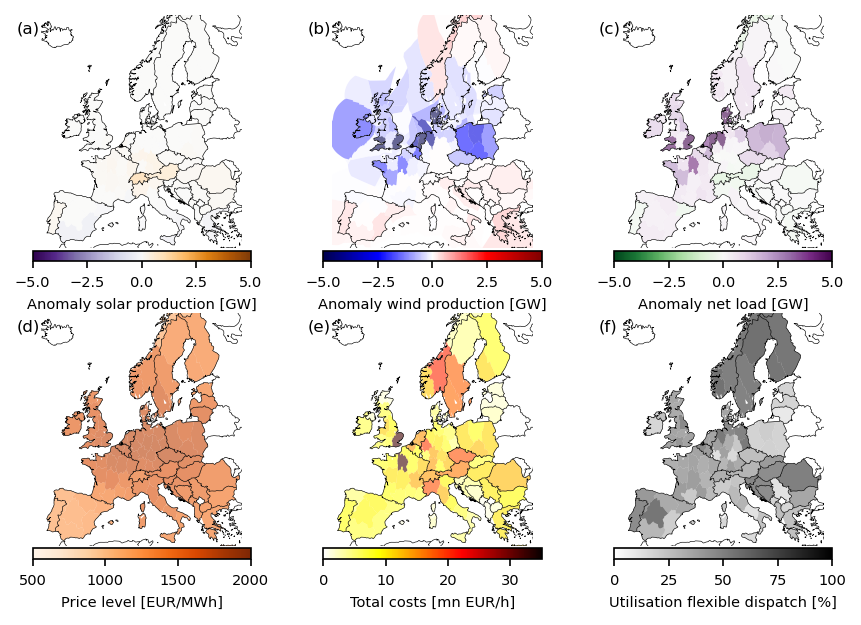

In [9]:
# Plot composite grid.

fig, axs = plt.subplots(2,3, figsize = (18*cm, 12*cm), subplot_kw={"projection": projection, "frame_on": False})

# Solar
ax = axs[0,0]
ax.text(-0.12, 0.92, "(a)", transform=ax.transAxes, fontsize=8)
plot_anomalies(
    "solar",
    n,
    cmap=mpl.cm.PuOr_r,
    norm = mpl.colors.Normalize(vmin=-5, vmax=5),
    regions=onshore_regions,
    periods=periods,
    caps=solar_caps,
    cfs=solar_cf,
    means=solar_means,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Anomaly solar production [GW]",
    scaling_factor = 1e-3,
)
# Wind
ax = axs[0,1]
ax.text(-0.12, 0.92, "(b)", transform=ax.transAxes, fontsize=8)
plot_anomalies(
    "wind",
    n,
    cmap=mpl.cm.seismic,
    norm = mpl.colors.Normalize(vmin=-5, vmax=5),
    regions=onshore_regions,
    periods=periods,
    caps=wind_caps,
    cfs=wind_cf,
    means=wind_means,
    ax = ax,
    projection = projection,
    offshore_regions=offshore_regions,
    cbar = True,
    cbar_label = "Anomaly wind production [GW]",
    scaling_factor = 1e-3,
)
# Net load
ax = axs[0,2]
ax.text(-0.12, 0.92, "(c)", transform=ax.transAxes, fontsize=8)
fake_caps = pd.DataFrame(index = nodal_net_load.columns, columns = wind_caps.columns)
fake_caps = fake_caps.fillna(1)
plot_anomalies(
    "net_load",
    n,
    cmap=mpl.cm.PRGn_r,
    norm = mpl.colors.Normalize(vmin=-5, vmax=5),
    regions=onshore_regions,
    periods=periods,
    caps=fake_caps,
    cfs=nodal_net_load,
    means=net_load_means,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Anomaly net load [GW]",
    scaling_factor = 1e-3,
)

# Price
ax = axs[1,0]
ax.text(-0.12, 0.92, "(d)", transform=ax.transAxes, fontsize=8)
plot_prices(
    n,
    cmap=mpl.cm.Oranges,
    norm = mpl.colors.Normalize(vmin=500, vmax=2000),
    regions=onshore_regions,
    nodal_prices = all_prices,
    periods=periods,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Price level [EUR/MWh]",
)
# Hourly costs
ax = axs[1,1]
ax.text(-0.12, 0.92, "(e)", transform=ax.transAxes, fontsize=8)
plot_total_costs(
    n,
    cmap=mpl.cm.hot_r,
    norm = mpl.colors.Normalize(vmin=0, vmax=35),
    regions=onshore_regions,
    nodal_costs = nodal_costs/1e6,
    periods=periods,
    ax = ax,
    projection = projection,
    cbar = True,
    cbar_label = "Total costs [mn EUR/h]",
)
# Fuel cell
ax = axs[1,2]
ax.text(-0.12, 0.92, "(f)", transform=ax.transAxes, fontsize=8)
plot_fc_util(
    n,
    cmap=mpl.cm.gist_gray_r,
    norm = mpl.colors.Normalize(vmin=0, vmax=100),
    regions=onshore_regions,
    periods=periods,
    fc_flex = rel_flex_df,
    projection = projection,
    cbar = True,
    cbar_label = "Utilisation flexible dispatch [%]",
    ax=ax,
    scaling_factor = 100,
)

fig.savefig("paper_plots/composite_grid.pdf", bbox_inches="tight")

# Figure 3: Clusters of SDEs

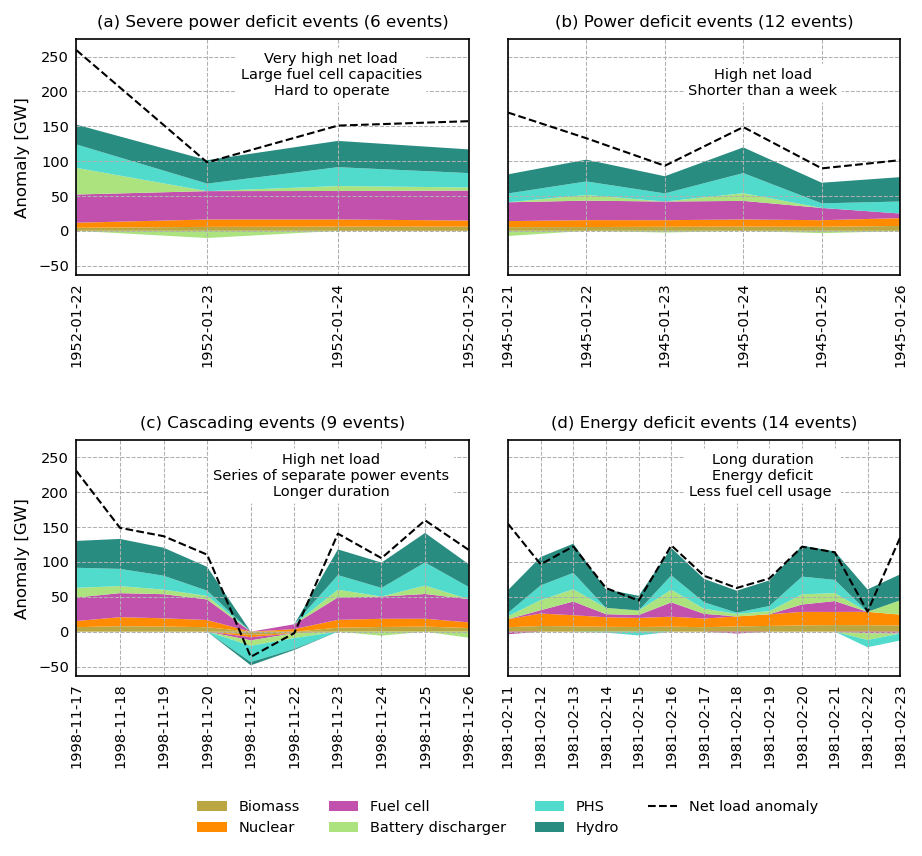

In [10]:
fig, axs = plt.subplots(2,2, figsize = (18*cm, 14*cm), sharey=True, gridspec_kw={"hspace": 0.7, "wspace": 0.1})

ax = axs.flatten()[0]
event_nr = 6
# Cluster 2: Extreme power deficit, event 6
ax.set_title("(a) Severe power deficit events (6 events)", fontsize=8)
plot_cluster_anomaly(all_flex_anomaly, all_system_anomaly, periods, event_nr, plot_all_system=False, resampled = "24h", ax=ax)
# Rotate tick labels on x-axis.
ax.tick_params(axis="x", labelsize=7, rotation=90, length=0)
ax.tick_params(axis="y", labelsize=7, length=0)
# Set length of ticks to be 0.

ax.set_ylabel("Anomaly [GW]", fontsize=8)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.yaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.xaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.set_xlim(periods.loc[event_nr, "start"].date(), periods.loc[event_nr, "end"].date())

# Add text inside plot
ax.annotate(
    "Very high net load\nLarge fuel cell capacities\nHard to operate",
    xy=(0.65, 0.75),
    xycoords="axes fraction",
    ha="center",
    va="bottom",
    fontsize=7,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", lw=0.5),
)


ax = axs.flatten()[1]
event_nr=2
# CLuster 3: Power deficit, event 2
ax.set_title("(b) Power deficit events (12 events)",fontsize=8)
plot_cluster_anomaly(all_flex_anomaly, all_system_anomaly, periods, event_nr, plot_all_system=False, resampled = "24h", ax=ax)
# Rotate tick labels on x-axis.
ax.tick_params(axis="x", labelsize=7, rotation=90, length=0)
ax.tick_params(axis="y", labelsize=7, length=0)
ax.yaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.xaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.set_xlim(periods.loc[event_nr, "start"].date(), periods.loc[event_nr, "end"].date())
ax.annotate(
    "High net load\nShorter than a week",
    xy=(0.65, 0.75),
    xycoords="axes fraction",
    ha="center",
    va="bottom",
    fontsize=7,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", lw=0.5),
)




ax = axs.flatten()[2]
event_nr=28
# Cluster 0: Cascading power deficit, event 28
ax.set_title("(c) Cascading events (9 events)", fontsize=8)
plot_cluster_anomaly(all_flex_anomaly, all_system_anomaly, periods, event_nr, plot_all_system=False, resampled = "24h", ax=ax)
# Rotate tick labels on x-axis.
ax.tick_params(axis="x", labelsize=7, rotation=90, length=0)
ax.tick_params(axis="y", labelsize=7, length=0)
ax.yaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.xaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.set_xlim(periods.loc[event_nr, "start"].date(), periods.loc[event_nr, "end"].date())
ax.set_ylabel("Anomaly [GW]", fontsize=8)
ax.annotate(
    "High net load\nSeries of separate power events\nLonger duration",
    xy=(0.65, 0.75),
    xycoords="axes fraction",
    ha="center",
    va="bottom",
    fontsize=7,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", lw=0.5),
)




ax = axs.flatten()[3]
event_nr=18
# Cluster 1: Energy deficit, event 18
ax.set_title("(d) Energy deficit events (14 events)", fontsize=8)
plot_cluster_anomaly(all_flex_anomaly, all_system_anomaly, periods, event_nr, plot_all_system=False, resampled = "24h", ax=ax)
# Rotate tick labels on x-axis.
ax.tick_params(axis="x", labelsize=7, rotation=90, length=0)
ax.tick_params(axis="y", labelsize=7, length=0)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.yaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.xaxis.grid(True, which="major", linestyle="dashed", linewidth=0.5)
ax.set_xlim(periods.loc[event_nr, "start"].date(), periods.loc[event_nr, "end"].date())
ax.annotate(
    "Long duration\nEnergy deficit\nLess fuel cell usage ",
    xy=(0.65, 0.75),
    xycoords="axes fraction",
    ha="center",
    va="bottom",
    fontsize=7,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", lw=0.5),
)

# Collect legend handles and labels from the first axis
handles, labels = axs.flatten()[0].get_legend_handles_labels()
pretty_labels = [
    "Biomass",
    "Nuclear",
    "Fuel cell",
    "Battery discharger",
    "PHS",
    "Hydro",
    "Net load anomaly",
]

# Add legend to the last axis
axs.flatten()[-1].legend(
            handles=handles,
            labels=pretty_labels,
            loc="center",
            bbox_to_anchor=(0, -0.6),
            frameon=False,
            ncols=4,
            fontsize=7,
        )
fig.savefig("paper_plots/cluster_overview.pdf", bbox_inches="tight")

# Figure 4: Dashboard of event 11

In [11]:
# Run _dashboard.py for dashboard/event_11.pdf

# Figure 5: Overview over SDEs (bubbles)

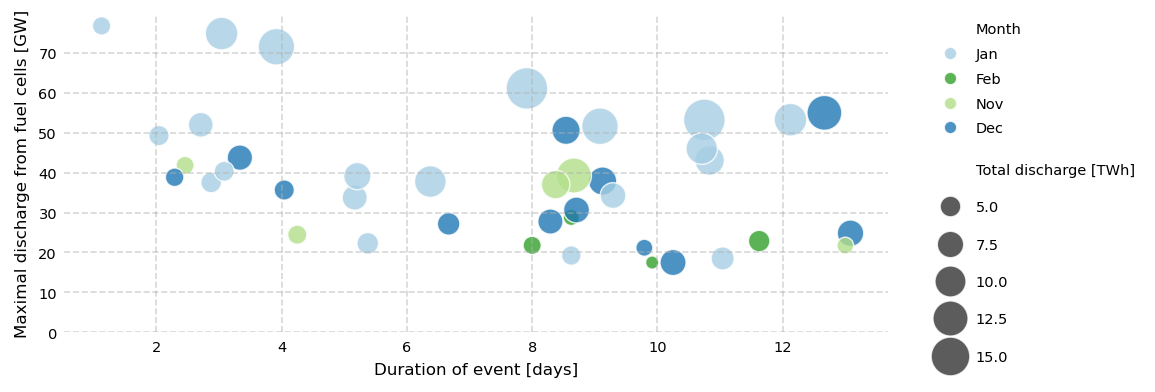

In [12]:
# Plot duration of event vs. maximal discharge per hour vs. total discharge (hydrogen) for each event.

fig, ax = plt.subplots(1,1, figsize = (18*cm, 7*cm))

severity = stores_periods[["start", "end", "peak_hour", "discharge", "max_fc_discharge"]].copy()
severity[["start", "end", "peak_hour"]] = severity[["start", "end", "peak_hour"]].apply(pd.to_datetime)
severity["duration"] = (severity["end"] - severity["start"]).dt.total_seconds() / (24 * 3600) #  in days
severity["month"] = severity["peak_hour"].dt.strftime('%b')

# Plot the maximal discharge per hour against the total discharge.
sns.scatterplot(
    x="duration",
    y="max_fc_discharge",
    size="discharge",
    sizes=(40, 400),  # Double the size range
    data=severity,
    alpha=0.8,
    hue="month",
    palette="Paired",  # Change the color scheme to 'viridis'
    ax=ax
)

# Aesthetics
ax.set_xlabel("Duration of event [days]", fontsize=8)
ax.set_ylabel("Maximal discharge from fuel cells [GW]", fontsize=8)
ax.set_ylim(0,None)
ax.tick_params(axis="both", length=0, labelsize=7)
ax.grid(axis="both", linestyle="--", alpha=0.5)

# Remove spines
for loc in ["top", "left", "bottom", "right"]:
    ax.spines[loc].set_visible(False)


# Adjust the legend to spread the values with more spacing
handles, labels = ax.get_legend_handles_labels()

# Rename labels.
for i in labels:
    if i == "month":
        labels[labels.index(i)] = "Month"
    elif i == "discharge":
        labels[labels.index(i)] = "Total discharge [TWh]"

# Reorder handles and labels manually.
handles = [handles[0], handles[1], handles[4], handles[3], handles[2], *handles[5:]]
labels = [labels[0], labels[1], labels[4], labels[3], labels[2], *labels[5:]]

second_legend = ax.legend(
    handles[:5],
    labels[:5],
    bbox_to_anchor=(1.05, 0.6),
    loc=3,
    borderaxespad=0.0,
    frameon=False,
    labelspacing=0.75,
    fontsize=7,
)
# Add the second legend to the plot
ax.add_artist(second_legend)

ax.legend(handles[5:], labels[5:], bbox_to_anchor=(1.05, 0.55), loc=2, borderaxespad=0.0, frameon=False, labelspacing=1.6, fontsize=7)




fig.savefig("paper_plots/events_overview.pdf", bbox_inches="tight")
plt.show()


# Figure 6: Robustness of SDE identifications across system configurations

In [13]:
sens_config_name = "stressful-weather-sensitivities"
cost_thresholds = [30,50, 100]
dict_names = [f"new_store_1941-2021_{c}bn_12-336h" for c in cost_thresholds]

sens_config, sens_scenario_def, years, sens_opt_networks = load_opt_networks(sens_config_name, load_networks=regenerate_data)

sens_periods = load_sens_periods(sens_config, cost_thresholds)


In [14]:
def clean_incidence_matrix(
        periods: pd.DataFrame, 
        sens_periods: dict, 
        scenario_list: list,
        ):
    """Create a cleaned incidence matrix for the sensitivity periods.

    Parameters:
    -----------
    periods: pd.DataFrame
        DataFrame with the periods.
    sens_periods: dict
        Dictionary with the sensitivity periods, where keys are scenario names and values scenario names.
    scenario_list: list
        List of scenarios to consider in the incidence matrix.

    Returns:
    --------
    np.ndarray
        Incidence matrix where rows correspond to scenarios and columns to periods.
    """
    matrix = np.zeros((len(scenario_list), len(periods)))
    for costs in reversed(sens_periods.keys()):
        for i, scenar in enumerate(scenario_list):
            if scenar == (90, 'c1.25', 'Co2L0.0'):
                matrix[i,:] = 4
            else:
                alt_periods = sens_periods[costs][scenar]
                if len(alt_periods) == 0:
                    matrix[i,:] = 0
                else:
                    for j, ind in enumerate(periods.index):
                        period = periods.loc[ind]
                        start = period.start.tz_localize(tz="UTC")
                        end = period.end.tz_localize(tz="UTC")
                        time_slice = pd.date_range(start, end, freq="h")
                        for k,alt_period in alt_periods.iterrows():
                            alt_time_slice = pd.date_range(alt_period.start, alt_period.end, freq="h")
                            if len(set(time_slice).intersection(set(alt_time_slice))) > 0:
                                matrix[i,j] +=1
                                break
    return matrix

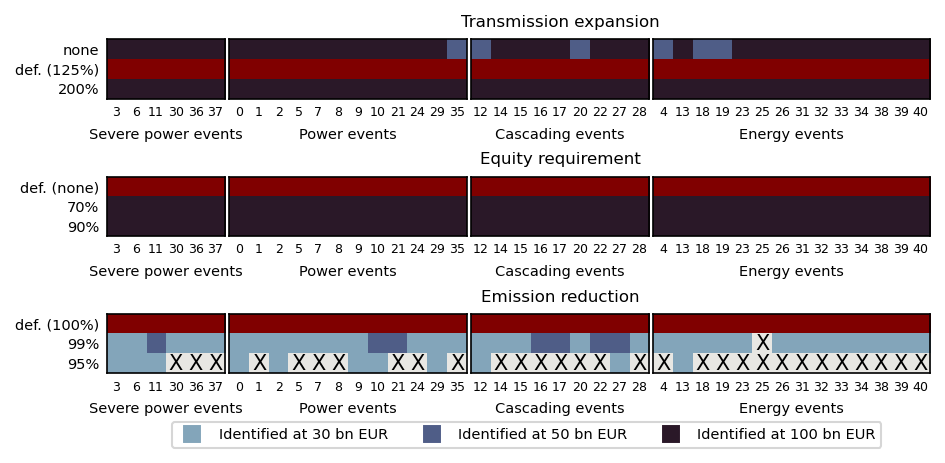

In [15]:
fig, axs = plt.subplots(3, 4, figsize = (18*cm, 9*cm), gridspec_kw={"hspace": 0.02, "width_ratios": [6, 12, 9, 14], "wspace": 0.02})

cmap_plot = mpl.colors.ListedColormap(['#E8E7E3','#83A5BA','#4F5D87', '#2A1828','maroon'])

periods_copied = periods.copy()
periods_copied["cluster"] = clusters

sorted_periods = periods_copied.sort_values(["cluster", "start"])

# Transmission scenarios
for column, cluster, name in zip(range(4), [2,3,0,1], ["Severe power", "Power", "Cascading", "Energy"]):
    cluster_periods = sorted_periods[sorted_periods["cluster"] == cluster]
    mat = clean_incidence_matrix(cluster_periods, sens_periods, [(90, 'c1.0', 'Co2L0.0'), (90, 'c1.25', 'Co2L0.0'),(90, 'c2', 'Co2L0.0')])
    plot_clean_incidence_matrix(mat, ylabels=["none", "def. (125%)", "200%"], cmap=cmap_plot, ax=axs[0, column])
    if column == 0:
        axs[0, column].set_yticklabels(["none", "def. (125%)", "200%"], fontsize=7)
    else:
        axs[0, column].set_yticklabels(["", "", ""], fontsize=7)
    if column == 2:
        axs[0, column].set_title("Transmission expansion", fontsize=8)
    axs[0, column].tick_params(axis="both", which="both", length=0)
    axs[0, column].xaxis.set_major_locator(MultipleLocator(1))
    axs[0, column].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[0, column].set_xticks(np.arange(len(cluster_periods)))
    axs[0, column].set_xticklabels(cluster_periods.index, fontsize=6)
    axs[0, column].set_xlabel(f"{name} events", fontsize=7)
    

# Equity scenarios
for column, cluster, name in zip(range(4), [2,3,0,1], ["Severe power", "Power", "Cascading", "Energy"]):
    cluster_periods = sorted_periods[sorted_periods["cluster"] == cluster]
    mat = clean_incidence_matrix(cluster_periods, sens_periods, [(90, 'c1.25', 'Co2L0.0'), (90, 'c1.25', 'Co2L0.0-EQ0.7'),(90, 'c1.25', 'Co2L0.0-EQ0.9')])
    plot_clean_incidence_matrix(mat, ylabels=["def. (none)", "70%", "90%"], cmap=cmap_plot, ax=axs[1, column])
    if column == 0:
        axs[1, column].set_yticklabels(["def. (none)", "70%", "90%"], fontsize=7)
    else:
        axs[1, column].set_yticklabels(["", "", ""], fontsize=7)
    if column == 2:
        axs[1, column].set_title("Equity requirement", fontsize=8)
    axs[1, column].tick_params(axis="both", which="both", length=0)
    axs[1, column].xaxis.set_major_locator(MultipleLocator(1))
    axs[1, column].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[1, column].set_xticks(np.arange(len(cluster_periods)))
    axs[1, column].set_xticklabels(cluster_periods.index, fontsize=6)
    axs[1, column].set_xlabel(f"{name} events", fontsize=7)
    

# Emission scenarios
for column, cluster, name in zip(range(4), [2,3,0,1], ["Severe power", "Power", "Cascading", "Energy"]):
    cluster_periods = sorted_periods[sorted_periods["cluster"] == cluster]
    mat = clean_incidence_matrix(cluster_periods, sens_periods, [(90, 'c1.25', 'Co2L0.0'), (90, 'c1.25', 'Co2L0.01'),(90, 'c1.25', 'Co2L0.05')])
    plot_clean_incidence_matrix(mat, ylabels=["def. (100%)", "99%", "95%"], cmap=cmap_plot, ax=axs[2, column])
    if column == 0:
        axs[2, column].set_yticklabels(["def. (100%)", "99%", "95%"], fontsize=7)
    else:
        axs[2, column].set_yticklabels(["", "", ""], fontsize=7)
    if column == 2:
        axs[2, column].set_title("Emission reduction", fontsize=8)
    axs[2, column].tick_params(axis="both", which="both", length=0)
    axs[2, column].xaxis.set_major_locator(MultipleLocator(1))
    axs[2, column].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[2, column].set_xticks(np.arange(len(cluster_periods)))
    axs[2, column].set_xticklabels(cluster_periods.index, fontsize=6)
    axs[2, column].set_xlabel(f"{name} events", fontsize=7)
    

# # # Add legend.
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Identified at 30 bn EUR', markerfacecolor='#83A5BA', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Identified at 50 bn EUR', markerfacecolor='#4F5D87', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Identified at 100 bn EUR', markerfacecolor='#2A1828', markersize=10)]
axs[2, 3].legend(handles=legend_elements, ncols=3, bbox_to_anchor=(0.85, -0.7), fontsize=7,)
fig.savefig("paper_plots/sensitivities.pdf", bbox_inches="tight")

# Figure 7: Resilience metrics

In [16]:
alt_config_name = "stressful-weather-sensitivities"
alt_config, alt_scenario_def, years, alt_opt_networks = load_opt_networks(alt_config_name, config_str = "base_s_90_elec_lc1.0_Co2L0.0", load_networks=regenerate_data)



# Load additional data
share_unserved = pd.read_csv(f"processing_data/{alt_config_name}/share_unserved.csv", index_col=0)
max_unserved = pd.read_csv(f"processing_data/{alt_config_name}/max_unserved.csv", index_col=0)
unserved = pd.read_csv(f"processing_data/{alt_config_name}/unserved.csv", index_col=0)
for df in [share_unserved, max_unserved, unserved]:
    df.index = [str(year) for year in years]
    df.columns = [str(year) for year in years]

# Unserved energy (in percent)
share_unserved_reorder = share_unserved.mean(axis="columns")
op_share_unserved_reorder = share_unserved.mean(axis="index")
share_unserved_reorder.index = system_costs.index
op_share_unserved_reorder.index = system_costs.index

# Max unserved load (in GW)
max_unserved_reorder = max_unserved.mean(axis="columns")
op_max_unserved_reorder = max_unserved.mean(axis="index")
max_unserved_reorder.index = system_costs.index
op_max_unserved_reorder.index = system_costs.index



In [17]:
# Rank years by difficulty of design year and operational year and compare whether these match.
ranked_years_ls = pd.DataFrame(index = years, columns = ["Design year", "Operational year", "SDE"]).astype(float)


sorted_design_years = max_unserved.T.describe().mean().sort_values().rank()
sorted_design_years.index = [int(i) for i in sorted_design_years.index]
sorted_operational_years = max_unserved.describe().mean().sort_values().rank(ascending=False)
sorted_operational_years.index = [int(i) for i in sorted_operational_years.index]
                                                                    
ranked_years_ls["Design year"] = sorted_design_years
ranked_years_ls["Operational year"] = sorted_operational_years
ranked_years_ls["SDE"] = 0
ranked_years_ls["System costs"] = reindex_opt_objs.sort_values().rank(ascending=False)
ranked_years_ls["Winter load"] = winter_load.sort_values("load").rank(ascending=False)
ranked_years_ls["Winter wind"] = winter_cfs.sort_values("wind").rank(ascending=True)["wind"]

for year in years:
    ranked_years_ls.loc[year, "Highest deficit"] = net_load.loc[f"{year}-07-01":f"{year+1}-06-30 23:00", "Net load"].max()
ranked_years_ls["Highest deficit"] = ranked_years_ls["Highest deficit"].sort_values().rank(ascending=False)

for i, period in periods.iterrows():
    net_year = get_net_year(period.start)
    ranked_years_ls.loc[net_year, "SDE"] = 1

ranked_years_ue = pd.DataFrame(index = years, columns = ["Design year", "Operational year"]).astype(float) 

sorted_design_years = share_unserved.T.describe().mean().sort_values().rank()
sorted_operational_years = share_unserved.describe().mean().sort_values().rank(ascending=False)
sorted_design_years.index = [int(i) for i in sorted_design_years.index]
sorted_operational_years.index = [int(i) for i in sorted_operational_years.index]                                                              
ranked_years_ue["Design year"] = sorted_design_years
ranked_years_ue["Operational year"] = sorted_operational_years


classification_years = ranked_years_ls.copy()
classification_years.rename(columns={"Design year": "Prevents peaks", "Operational year": "Causes peaks", "Highest deficit": "Highest net load"}, inplace=True)
classification_years["Causes deficit"] = ranked_years_ue["Operational year"].astype(int)
classification_years["Prevents deficits"] = ranked_years_ue["Design year"].astype(int)
classification_years["Lowest annual solar CF"] = annual_cfs.sort_values("solar").rank(ascending=True)["solar"].astype(int)
classification_years["Lowest annual wind CF"] = annual_cfs.sort_values("wind").rank(ascending=True)["wind"].astype(int)

# Reorder according to the following categories:
# - Annual values: total system costs, solar cf, wind cf
# - Winter / weather: winter load
# - Operational: causes deficit, prevents deficits
# - SDE: SDE, highest net load, prevents peaks, causes peaks

classification_years = classification_years[["System costs", "Lowest annual solar CF", "Lowest annual wind CF", "Winter load", "Causes deficit", "Prevents deficits", "SDE", "Highest net load", "Prevents peaks", "Causes peaks",
]]

# Only keep years that have a value below 6 (except SDE)
filtered_classification_years = classification_years.drop("SDE", axis="columns")
filtered_classification_years = filtered_classification_years[filtered_classification_years < 5].dropna(how="all")
filtered_classification_years["SDE"] = classification_years["SDE"]
filtered_classification_years = filtered_classification_years.T

/tmp/ipykernel_82197/2150811964.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handles=handles, labels=labels, ncol=4, loc="upper left", fontsize=7, bbox_to_anchor=(0.1, -0.25), borderaxespad=0.0, frameon=False, labelspacing=0.75)


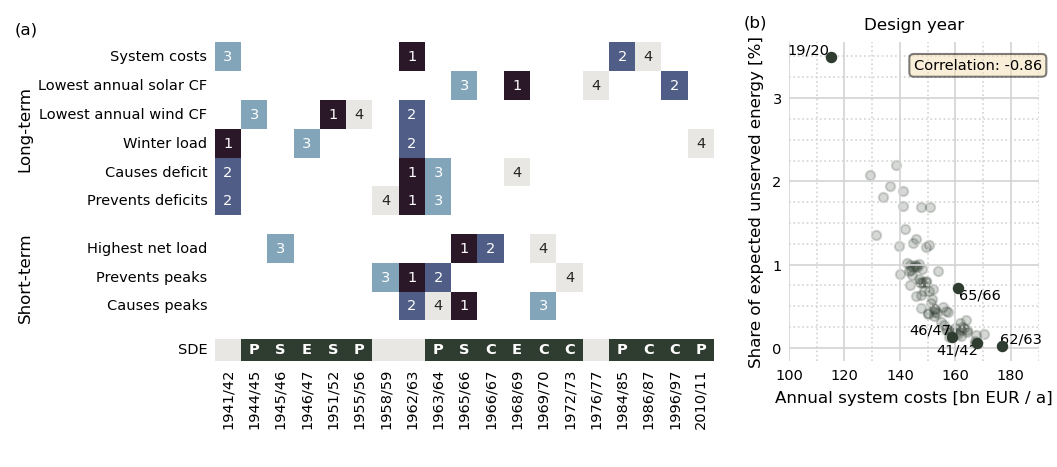

In [18]:
# Plot seaborn heatmap of classification years with breaks for each category. Add scatter plot of total costs vs share of unserved energy.

fig, axd = plt.subplot_mosaic(
    mosaic = [["long_term", "corr"],
                ["short_term", "corr"],
                ["sde", "corr"]],
    width_ratios=[12, 6],
    height_ratios=[8, 4, 1],
    figsize=(18 * cm, 7* cm),
    sharex=False,
)

# Colour bars and norms for heatmap
norm = mpl.colors.Normalize(vmin=1, vmax=5)
norm_bin = mpl.colors.Normalize(vmin=0.1, vmax=1, clip=True)

ax = axd["long_term"]
ax.text(-0.4, 1.05, "(a)", transform=ax.transAxes, fontsize=8)
sns.heatmap(filtered_classification_years.loc[["System costs", "Lowest annual solar CF", "Lowest annual wind CF", "Winter load", "Causes deficit", "Prevents deficits",]], 
cmap=cmap_midnights, ax=ax, cbar=False, annot=True,annot_kws={"size": 7})

# Add annotation (rotated) left of the x-axis with a square bracket classifying all these as "Long-term resilience metrics"
ax.text(-0.38, 0.5, "Long-term", rotation=90, ha="center", va="center", fontsize=8, transform=ax.transAxes)

ax = axd["short_term"]
sns.heatmap(filtered_classification_years.loc[["Highest net load", "Prevents peaks", "Causes peaks", #"Battery installed", "H2 installed"
]], 
cmap=cmap_midnights, ax=ax, cbar=False, annot=True,annot_kws={"size": 7})
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_yticklabels(["Highest net load", "Prevents peaks", "Causes peaks"])

# Add annotation (rotated) left of the x-axis with a square bracket classifying all these as "Short-term resilience metrics"
ax.text(-0.38, 0.5, "Short-term", rotation=90, ha="center", va="center", fontsize=8, transform=ax.transAxes)



ax = axd["sde"]
sns.heatmap(filtered_classification_years.loc[["SDE"]], cmap=cmap_two, ax=ax, cbar=False)
# Add annotations within the heatmap for each SDE.
cluster_keys = {"0": "C", "1": "E", "2": "S", "3": "P"} # Cascading, energy, severe, power
for i, y in enumerate(filtered_classification_years.columns):
    if filtered_classification_years.loc["SDE", y] == 1:
        for period_nr, period in periods.iterrows():
            net_year = get_net_year(period.start)
            if net_year == y:
                ax.text(i + 0.5, 0.5, cluster_keys[str(clusters.loc[period_nr])], ha="center", va="center", fontsize=7, color="white", weight="bold")
                break
ax.set_xticklabels([f"{y}/{str(y+1)[2:]}" for y in filtered_classification_years.columns], rotation=90, ha="center", fontsize=7)



for ax in [axd["long_term"], axd["short_term"], axd["sde"]]:
    ax.set_xlabel("")
    # Set length of y tick markers to 0.
    ax.tick_params(axis="both", length=0, labelsize=7)
    # Use all indices for y ticks.
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

for ax in [axd["long_term"], axd["short_term"]]:
    # No x-ticks and x-tick labels.
    ax.set_xticks([])
    ax.set_xticklabels([])


# # Scatter plot.
ax = axd["corr"]
ax.text(-0.18, 1.05, "(b)", transform=ax.transAxes, fontsize=8)
ax.scatter(system_costs, share_unserved_reorder, color="#2F3C30", alpha=0.2, s=20)

# Add correlation.
corr = system_costs.corr(share_unserved_reorder)
ax.text(0.5, 0.95, f"Correlation: {corr:.2f}", transform=ax.transAxes, fontsize=7,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Annotate some years such as "62/63", "41/42", "19/20", "46/47", and "65/66"
for i, txt in enumerate(system_costs.index):
    if txt in ["19/20", "46/47"]:
        ax.annotate(txt, (system_costs[i] - 0.5, share_unserved_reorder[i]), fontsize=7, ha='right', va='bottom', color="black")
    # Annotate "65/66" to the bottom right
    if txt in ["65/66"]:
        ax.annotate(txt, (system_costs[i] + 0.5, share_unserved_reorder[i]), fontsize=7, ha='left', va='top', color="black")
    # Annotate  "41/42" to the bottom left
    if txt in ["41/42"]:
        ax.annotate(txt, (system_costs[i] + 0.5, share_unserved_reorder[i]), fontsize=7, ha='right', va='top', color="black")
    # Annotate "62/63" to the top right
    if txt in ["62/63"]:
        ax.annotate(txt, (system_costs[i] - 0.5, share_unserved_reorder[i]), fontsize=7, ha='left', va='bottom', color="black")
# Scatter plot only those above years with full opacity
ax.scatter(system_costs[["19/20", "46/47", "62/63", "41/42", "65/66"]], share_unserved_reorder[["19/20", "46/47", "62/63", "41/42", "65/66"]], color="#2F3C30", alpha=1, s=20, zorder=3)
ax.set_ylabel("Share of expected unserved energy [%]", fontsize=8)
ax.set_title("Design year", fontsize=8)

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

# Labels
ax.set_xlabel("Annual system costs [bn EUR / a]", fontsize=8)


# # Legend
handles, labels = ax.get_legend_handles_labels()
sns.despine(ax=axd["corr"], left=True, bottom=True)
ax.tick_params(axis="y", which="both", length=0, labelsize=7,rotation=0)
ax.tick_params(axis="x", which="both", length=0, labelsize=7,rotation=0)

# Ticks, grid

axd["corr"].xaxis.set_major_locator(MultipleLocator(20))
axd["corr"].xaxis.set_major_formatter(FormatStrFormatter('%d'))
axd["corr"].xaxis.set_minor_locator(AutoMinorLocator(2))
axd["corr"].xaxis.grid(color='lightgray', linestyle='solid', which='major')
axd["corr"].xaxis.grid(color='lightgray', linestyle='dotted', which='minor')
ax.legend(handles=handles, labels=labels, ncol=4, loc="upper left", fontsize=7, bbox_to_anchor=(0.1, -0.25), borderaxespad=0.0, frameon=False, labelspacing=0.75)
axd["corr"].set_xlim(100, 190)


axd["corr"].yaxis.grid(color='lightgray', linestyle='solid', which='major')
axd["corr"].yaxis.grid(color='lightgray', linestyle='dotted', which='minor')

fig.savefig("paper_plots/short_term_vs_long_term_corr.pdf", bbox_inches="tight")